# Generate Jobs Report Data for Chartbook

Brian Dew

@bd_econ

In [2]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### API Request

In [2]:
# Series stored as a dictionary
series = {'LNS14000003': 'White', 
          'LNS14000006': 'Black',
          'LNS14000009': 'Hispanic',
          'LNS14032183': 'Asian',
          'LNS14000000': 'Total',
          'LNS13327709': 'U6',
          'LNS13000000': 'Level',
          'LNU03008636': 'LT',
          'LNU03008516': 'MT',
          'LNU00000000': 'POP',
          'LNS12300060': 'PA_EPOP',
          'LNS13023621': 'Job Loser',
          'LNS13023653': 'Temporary Layoff',
          'LNS13026638': 'Permanent Separation',
          'LNS13023705': 'Job Leaver', 
          'LNS13023557': 'Re-entrant',
          'LNS13023569': 'New entrant',
          'LNS13008276': 'Median',
          'LNS13008275': 'Mean',
          'LNS17200000': 'NILF',
          'LNS17100000': 'UNEMP',
          'LNS11000000': 'LF',
          'LNS12032194': 'PTECON'}

# Start year and end year
dates = (1988, 2021)
df = bls_api(series, dates, bls_key)
df.to_csv(data_dir / 'jobs_report_main.csv', index_label='date')
print(dtxt(df.index[-1])['mon1'])

Post Request Status: REQUEST_SUCCEEDED
April 2021


In [3]:
# Series stored as a dictionary
series = {'CES0500000003': 'ALL', 
          'CES0500000008': 'PNS',
          'LNS12005054': 'avghrstot',
          'LNU02033699': 'avghrsserv',
          'CES0500000002': 'ceshrstot',
          'CES0600000002': 'ceshrsgoods',
          'CES0800000002': 'ceshrsserv',
          'CES0500000007': 'ceshrspns',
          'CES9000000001': 'govjobs',
          'LNU02033232': 'avghrsptecon',
          'LEU0252911200': 'p10uwe',
          'LEU0252911300': 'p25uwe',
          'LEU0252881500': 'p50uwe',
          'LEU0252911400': 'p75uwe',
          'LEU0252911500': 'p90uwe',
          'LEU0254466800': 'nuwe',
          'LNU02026619': 'MJH',
          'LNU02000000': 'EMP',
          'LNU00000001': 'MenPop',
          'LNU00000002': 'WomenPop',
          'LNU01000001': 'MenLF',
          'LNU01000002': 'WomenLF',
          'LNS11300001': 'MenLFPR',
          'LNS11300002': 'WomenLFPR'}

# Start year and end year
dates = (1988, 2021)
df = bls_api(series, dates, bls_key)
df.to_csv(data_dir / 'jobs_report_main2.csv', index_label='date')

Post Request Status: REQUEST_SUCCEEDED


In [4]:
# Series stored as a dictionary
series = {'LNS17100001': 'MenUE',
          'LNS17100002': 'WomenUE',
          'LNS17200001': 'MenNE',
          'LNS17200002': 'WomenNE',
          'LNS17400001': 'MenEU',
          'LNS17400002': 'WomenEU',
          'LNS17600001': 'MenNU',
          'LNS17600002': 'WomenNU',
          'LNS17800001': 'MenEN',
          'LNS17800002': 'WomenEN',
          'LNS17900001': 'MenUN',
          'LNS17900002': 'WomenUN',
          'LNS12000001': 'MenE',
          'LNS12000002': 'WomenE',
          'LNS13000001': 'MenU',
          'LNS13000002': 'WomenU',
          'LNS15000001': 'MenN',
          'LNS15000002': 'WomenN'}

# Start year and end year
dates = (2018, 2021)
df = bls_api(series, dates, bls_key)
df.to_csv(data_dir / 'jobs_report_main3.csv', index_label='date')

Post Request Status: REQUEST_SUCCEEDED


### Labor Force Gross Flows

In [5]:
df = (pd.read_csv(data_dir / 'jobs_report_main3.csv', parse_dates=['date'])
        .set_index('date')) / 1000

cols = ['MenEU', 'WomenEU', 'MenEN', 'WomenEN', 'MenUE', 'WomenUE',
        'MenUN', 'WomenUN', 'MenNE', 'WomenNE', 'MenNU', 'WomenNU']

cols2 = []
for col in cols:
    name = f'{col}{col[-2]}'
    cols2.append(name)
    df[name] = (df[col] / df[f'{col[:-2]}{col[-2]}'].shift()) * 100

df.loc['2013-01-01':, cols2].to_csv(data_dir / 'grosslf.csv', index_label='date')

### Unemployment rate

In [2]:
df = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date'))
srs = ['Total', 'U6']
df.loc['1989':, srs].to_csv(data_dir / 'unemp2.csv', index_label='date')

srs = ['White', 'Black', 'Hispanic']
df.loc['1989':, srs].to_csv(data_dir / 'unemp.csv', index_label='date')

s = series_info(df['Level'])
s2 = series_info(df['Total'])
s3 = series_info(df['Black'])
s4 = series_info(df['U6'])
compare = compare_text(df['Total'].iloc[-1], df['Total'].iloc[-2], [0.15, 1.5, 3.0])
compare2 = compare_text(df['Total'].iloc[-1], df['Total'].iloc[-13], [0.15, 1.5, 3.0])
pryrdt = dtxt(df.index[-13])['mon1']

if compare[-5:] != compare2[-5:]:
    conj = f', but {compare2} the {pryrdt} rate of {df["Total"].iloc[-13]:.1f} percent'
elif compare != compare2:
    conj = f', and {compare2} the {pryrdt} rate of {df["Total"].iloc[-13]:.1f} percent'
else:
    conj = ''
    
text = ('BLS \href{https://www.bls.gov/news.release/empsit.nr0.htm}{reports} '+
        f'{s["val_latest"]/1000:.1f} million '+
        f'unemployed persons in {s["date_latest_ft"]}, '+
        f'and an unemployment rate of {s2["val_latest"]} percent '+
        '(see {\color{blue!50!cyan}\\textbf{---}}), '+
        f'{compare} the {s["date_prev_ft"]} rate of {s2["val_prev"]} percent'+
        f'{conj}.')
write_txt(text_dir / 'unemp1.txt', text)
print(text, '\n')

mval = f', {s4["last_matched"]}.' if s4['days_since_match'] > 1000 else '.'
text = (f'In {s["date_latest_ft"]}, the labor under-utilization rate is '+
        f'{s4["val_latest"]} percent '+
        '(see {\color{blue}\\textbf{---}})'+
        f'{mval}')
write_txt(text_dir / 'unemp2.txt', text)
print(text, '\n')

write_txt(text_dir / 'u6_node.txt', end_node3(df['U6'], 'blue'))
write_txt(text_dir / 'u3_node.txt', end_node3(df['Total'], 'blue!50!cyan'))

black_ch = df['Black'].iloc[-1] - df.loc['2020-02-01', 'Black']
text = ('Unemployment is much more common for disadvantaged groups, '+
        'with the black or African American unemployment rate typically double '+
        'the white unemployment rate. '+
        'A very tight labor market may have the effect of reducing racial '+
        'discrimination in hiring. However, disadvantaged groups are more likely to '+
        'lose jobs in a downturn. As a result, the full-employment portion '+
        'of the business cycle is quite short for many people. '
        'Since February 2020, the black unemployment rate '+
        f'has increased by {black_ch:.1f} percentage '+
        f'points to {s3["val_latest"]:.1f} percent '+
        '(see {\color{green!50!teal!60!black}\\textbf{---}}).')
write_txt(text_dir / 'unemp3.txt', text)
print(text)

BLS \href{https://www.bls.gov/news.release/empsit.nr0.htm}{reports} 9.8 million unemployed persons in April 2021, and an unemployment rate of 6.1 percent (see {\color{blue!50!cyan}\textbf{---}}), in line with the March 2021 rate of 6.0 percent, but far below the April 2020 rate of 14.8 percent. 

In April 2021, the labor under-utilization rate is 10.4 percent (see {\color{blue}\textbf{---}}). 

Unemployment is much more common for disadvantaged groups, with the black or African American unemployment rate typically double the white unemployment rate. A very tight labor market may have the effect of reducing racial discrimination in hiring. However, disadvantaged groups are more likely to lose jobs in a downturn. As a result, the full-employment portion of the business cycle is quite short for many people. Since February 2020, the black unemployment rate has increased by 3.7 percentage points to 9.7 percent (see {\color{green!50!teal!60!black}\textbf{---}}).


In [7]:
srs = ['U6', 'Total', 'White', 'Black', 'Hispanic', 'Asian']
untab = df[srs].iloc[-6:].iloc[::-1].T
untab.columns = untab.columns.strftime('%b `%y')
untab['GFC peak'] = df.loc['2005':'2013', srs].max()
untab['Date'] = df.loc['2005':'2013', srs].idxmax().dt.strftime('%b `%y')
d = {'Total': 'Unemployment Rate (U3)',
     'U6': 'Under-utilization Rate (U6)',
     'White': '\hspace{2mm} White',
     'Black': '\hspace{2mm} Black',
     'Hispanic': '\hspace{2mm} Hispanic',
     'Asian': '\hspace{2mm} Asian'}
untab.index = untab.index.map(d)

untab.loc['\\textit{by race/ethnicity:}', untab.columns] = [''] * 8
untab = untab.iloc[0:2].append(untab.iloc[-1]).append(untab.iloc[2:6])
untab.columns.name = None
untab.to_csv(data_dir / 'unemp1.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

untab

,Apr `21,Mar `21,Feb `21,Jan `21,Dec `20,Nov `20,GFC peak,Date
Under-utilization Rate (U6),10.4,10.7,11.1,11.1,11.7,12.0,17.2,Dec `09
Unemployment Rate (U3),6.1,6.0,6.2,6.3,6.7,6.7,10.0,Oct `09
\textit{by race/ethnicity:},,,,,,,,
\hspace{2mm} White,5.3,5.4,5.6,5.7,6.0,5.9,9.2,Oct `09
\hspace{2mm} Black,9.7,9.6,9.9,9.2,9.9,10.3,16.8,Mar `10
\hspace{2mm} Hispanic,7.9,7.9,8.5,8.6,9.3,8.4,13.0,Aug `09
\hspace{2mm} Asian,5.7,6.0,5.1,6.6,5.9,6.7,8.4,Dec `09


### Labor Force Participation Rate

In [8]:
tcol = 'green!80!blue'
mcol = 'blue!80!cyan'
wcol = 'orange'

df = (pd.read_csv(data_dir / 'jobs_report_main2.csv', parse_dates=['date'])
        .set_index('date'))[['MenLFPR', 'WomenLFPR']]

df2 = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
         .assign(TotLFPR = lambda x: (x.LF / x.POP)*100)
         .set_index('date'))['TotLFPR']

df['TotLFPR'] = df2
df.loc['1989':].to_csv(data_dir / 'lfpr.csv', index_label='date')

write_txt(text_dir / 'totlfpr_node.txt', end_node3(df['TotLFPR'], tcol))
write_txt(text_dir / 'menlfpr_node.txt', end_node3(df['MenLFPR'], mcol))
write_txt(text_dir / 'womenlfpr_node.txt', end_node3(df['WomenLFPR'], wcol))

ltdate = dtxt(df.index[-1])['mon1']
ltval = df['TotLFPR'].iloc[-1]
prval = df['TotLFPR'].iloc[-2]
if dtxt(df.index[-1])['year'] == dtxt(df.index[-2])['year']:
    prmonth = dtxt(df.index[-2])['mon3']
else:
    prmonth = dtxt(df.index[-2])['mon1']
prval2 = df['TotLFPR'].iloc[-3]
if dtxt(df.index[-1])['year'] == dtxt(df.index[-3])['year']:
    prmonth2 = dtxt(df.index[-3])['mon3']
else:
    prmonth2 = dtxt(df.index[-3])['mon1']
feb20val = df['TotLFPR'].loc['2020-02-01']

text = (f'In the latest data, covering {ltdate}, {ltval:.1f} percent of people age 16 and '+
        'older are in the labor force (see {\\color{green!80!blue}\\textbf{---}}), '+
        f'compared to {prval:.1f} percent in {prmonth} '+
        f'and {prval2:.1f} percent in {prmonth2}. In February 2020, when US '+
        'confirmed cases of COVID-19 were still low, this labor force participation '+
        f'rate was {feb20val:.1f} percent. ')
print(text)
write_txt(text_dir / 'lfpr_text.txt', text)

mltval = df['MenLFPR'].iloc[-1]
wltval = df['WomenLFPR'].iloc[-1]
mchval = mltval - df['MenLFPR'].loc['2020-01-01']
wchval = wltval - df['WomenLFPR'].loc['2020-01-01']
mch = value_text(mchval, style='increase', ptype='pp')
wch = value_text(wchval, style='increase', ptype='pp')

text = (f'In {ltdate}, {mltval:.1f} percent of men age 16+ are in '+
        'the labor force (see {\\color{blue!80!cyan}\\textbf{---}}), '+
        f'compared to {wltval:.1f} percent of women '+
        '(see {\\color{orange}\\textbf{---}}). Since February '+
        f'2020, labor force participation has {mch} among men, '+
        f'and {wch} among women.')
print(text)
write_txt(text_dir / 'lfpr_text2.txt', text)

In the latest data, covering April 2021, 61.7 percent of people age 16 and older are in the labor force (see {\color{green!80!blue}\textbf{---}}), compared to 61.5 percent in March and 61.4 percent in February. In February 2020, when US confirmed cases of COVID-19 were still low, this labor force participation rate was 63.3 percent. 
In April 2021, 67.6 percent of men age 16+ are in the labor force (see {\color{blue!80!cyan}\textbf{---}}), compared to 56.1 percent of women (see {\color{orange}\textbf{---}}). Since February 2020, labor force participation has decreased 1.7 percentage points among men, and decreased 1.7 percentage points among women.


### Employment rate

In [4]:
df = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date')).loc['1989':, 'PA_EPOP']

df.to_csv(data_dir / 'epop.csv', index_label='date')

write_txt(text_dir / 'epop_node.txt', end_node(df, 'blue!90!cyan', date=True))

d = series_info(df)

text = f'In {d["date_latest_ft"]}, {d["val_latest"]} percent'

if (d['days_since_match'] > 725) | (d['days_since_match'] == 0):
    text2 = d['last_matched']
else:
    text2 = f'compared to {d["val_prev"]} percent in {d["date_prev_ft"]}'
    
if d['change_year_ago'] > 0:
    direction = 'increased'
    value = d['change_year_ago']
    label = (f'Over the past year, the age 25-54 employment rate has '+
             f'{direction} by {value:.1f} percentage points.')
elif d['change_year_ago'] < 0:
    direction = 'fallen'
    value = abs(d['change_year_ago'])
    label = (f'Over the past year, the age 25-54 employment rate has '+
             f'{direction} by {value:.1f} percentage points.')
else:
    label = 'The age 25-54 employment rate is unchanged over the past year. '
    
pop = 126277
diff1 = d['late90s'] - d['val_latest']
diff = (d['late90s'] - d['val_latest']) / 100 * pop

if diff > 999:
    diff_text = f'{round(diff / 1000, 1)} million'
else: 
    diff_text = f'{round(diff, -1)} thousand'
    
label2 = (f'The current age 25-54 employment rate is {diff1:.1f} percentage '+
          f'points (equivalent to {diff_text} workers) below the average during '+
          '1998--99, a period with a particularly tight labor market. ')

textval = f'{text} of 25-54 years olds were employed, {text2}. {label} {label2}'
print(textval)

write_txt(text_dir / 'epop_text.txt', textval)

In April 2021, 76.9 percent of 25-54 years olds were employed, compared to 76.8 percent in March 2021. Over the past year, the age 25-54 employment rate has increased by 7.3 percentage points. The current age 25-54 employment rate is 4.4 percentage points (equivalent to 5.5 million workers) below the average during 1998--99, a period with a particularly tight labor market. 


### Unemployment by reason

In [2]:
srs = ['Job Loser', 'Job Leaver', 'Re-entrant', 'New entrant', 
       'Temporary Layoff', 'Permanent Separation', 'Level']
d1 = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date')).loc['1989':]

df = d1[srs].div(d1['LF'], axis='index') * 100
#.resample('QS').mean()
df.to_csv(data_dir / 'unemp_reason.csv', index_label='date', float_format='%g')

loser = df['Job Loser'].iloc[-1]
tl = df['Temporary Layoff'].iloc[-1]
tlsh = (d1['Temporary Layoff'] / d1['Level']).iloc[-1] * 100
leaver = df['Job Leaver'].iloc[-1]
reent = df['Re-entrant'].iloc[-1]
newent = df['New entrant'].iloc[-1]
ltdate = dtxt(df.index[-1])['mon1']

text = (f'In {ltdate}, {loser:.1f} percent of the labor force '+
        'were unemployed because of losing a job or having a temporary '+
        f'job end. Of these, {tl:.1f} percent of the labor force are unemployed due '+
        f'to temporary layoff, equivalent to {tlsh:.1f} percent of the unemployed. '+
        f'Additionally, {leaver:.1f} percent of the labor force were re-entrants, '+
        f'{reent:.1f} percent were new entrants, and {newent:.1f} '+
        'percent were job leavers. ')
write_txt(text_dir / 'unemp_reason.txt', text)
print(text)

In April 2021, 4.0 percent of the labor force were unemployed because of losing a job or having a temporary job end. Of these, 1.3 percent of the labor force are unemployed due to temporary layoff, equivalent to 21.5 percent of the unemployed. Additionally, 0.5 percent of the labor force were re-entrants, 1.3 percent were new entrants, and 0.4 percent were job leavers. 


In [3]:
lf = ['Employed', 'Unemployed']
naw_rate = lambda x: np.average(x['NOTATWORK'], weights=x['BASICWGT'])

naw = pd.Series(dtype='float64')

columns = ['LFS', 'MONTH', 'YEAR', 'BASICWGT', 'NOTATWORK']
for year in range(2017, 2022):
    data = (pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
        .query('LFS in @lf'))
    data1 = data.groupby(['YEAR', 'MONTH']).apply(naw_rate) * 100
    data1.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data1.index]
    naw = naw.append(data1)

df['Employed, Not at Work'] = naw

In [4]:
d = {'Level': 'Unemployed, Any Reason',
     'Job Loser': '\hspace{2mm}Job Loser',
     'Temporary Layoff': '\hspace{4mm}Temporary Layoff',
     'Permanent Separation': '\hspace{4mm}Permanent Separation',
     'Re-entrant': '\hspace{2mm}Re-entrant',
     'New entrant': '\hspace{2mm}New entrant',
     'Job Leaver': '\hspace{2mm}Job Leaver'}

final = pd.DataFrame()

loc_list = [-1, -2, -3, -4, -5, -13, -14, -15, -16, -17]

for key, value in d.items():
    for i in loc_list:
        final.loc[value, dtxt(df.index[i])['mon6']] = df[key].iloc[i].round(1)
        
final.loc['\\textit{See also:}', final.columns] = [''] * 10
final.loc['Employed, Not at Work', final.columns] = [df['Employed, Not at Work'].iloc[i].round(1) 
                                                     for i in loc_list]

final.to_csv(data_dir / 'unempreason_table.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

In [5]:
final

,Apr `21,Mar `21,Feb `21,Jan `21,Dec `20,Apr `20,Mar `20,Feb `20,Jan `20,Dec `19
"Unemployed, Any Reason",6.1,6.0,6.2,6.3,6.7,14.8,4.4,3.5,3.5,3.6
\hspace{2mm}Job Loser,4.0,3.9,4.1,4.4,4.5,13.2,2.6,1.6,1.6,1.6
\hspace{4mm}Temporary Layoff,1.3,1.3,1.4,1.7,1.9,11.5,1.3,0.5,0.4,0.5
\hspace{4mm}Permanent Separation,2.2,2.1,2.2,2.2,2.1,1.3,0.9,0.8,0.8,0.8
\hspace{2mm}Re-entrant,1.3,1.4,1.3,1.2,1.4,1.0,1.1,1.1,1.1,1.1
\hspace{2mm}New entrant,0.4,0.3,0.4,0.3,0.3,0.3,0.3,0.3,0.3,0.3
\hspace{2mm}Job Leaver,0.5,0.5,0.4,0.4,0.5,0.4,0.4,0.5,0.5,0.5
\textit{See also:},,,,,,,,,,
"Employed, Not at Work",3.1,2.8,3.4,3.5,3.5,7.4,4.0,2.5,2.7,2.6


### Unemployed long-term

In [14]:
srs = ['LT', 'MT', 'POP']
df = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date')).loc['1989':, srs]

data = (df.divide(df['POP'], axis=0) * 100).drop(['POP'], axis=1)
data.to_csv(data_dir / 'ltu.csv', index_label='date', float_format='%g')

write_txt(text_dir / 'ltu_node.txt', end_node(data['LT'], 'blue'))
write_txt(text_dir / 'ltu_node2.txt', end_node(data['MT'], 'red'))

ldate = dtxt(data.index[-1])['mon1']
pdate = dtxt(data.index[-13])['mon1']
hdate = dtxt(data['LT'].idxmax())['mon1']
prdt = dtxt(data.index[-2])['mon1']
prdt2 = dtxt(data.index[-3])['mon1']

recent_min = data.loc['2015':, 'LT'].min()
recent_min_dt = dtxt(data.loc['2015':, 'LT'].idxmin())['mon1']

text = (f'As of {ldate}, BLS '+
        '\href{https://www.bls.gov/webapps/legacy/cpsatab12.htm}{reports} '+
        f'that {data["LT"].iloc[-1]:.2f} percent of the age 16+ '+
         'population have been unemployed for 27 weeks or longer, '+
        f'compared to {data["LT"].iloc[-13]:.2f} percent in {pdate} '+
        '(see {\color{blue}\\textbf{---}}). This measure of long-term '+
        f'unemployment peaked at {data["LT"].max():.2f} percent of the '+
        f'population in {hdate}, but had fallen to {recent_min:.2f} percent '+
        f'in {recent_min_dt}. \n \nIn {ldate}, {data["MT"].iloc[-1]:.2f} '+
        'percent of the age 16+ population are unemployed for at '+
        f'least 15 weeks, following {data["MT"].iloc[-2]:.2f} percent in {prdt}, '+
        f'and {data["MT"].iloc[-3]:.2f} percent in {prdt2}.')
write_txt(text_dir / 'ltu.txt', text)
print(text)

As of April 2021, BLS \href{https://www.bls.gov/webapps/legacy/cpsatab12.htm}{reports} that 1.57 percent of the age 16+ population have been unemployed for 27 weeks or longer, compared to 0.36 percent in April 2020 (see {\color{blue}\textbf{---}}). This measure of long-term unemployment peaked at 2.96 percent of the population in April 2010, but had fallen to 0.36 percent in April 2020. 
 
In April 2021, 2.12 percent of the age 16+ population are unemployed for at least 15 weeks, following 2.26 percent in March 2021, and 2.20 percent in February 2021.


### Duration of Unemployment

In [15]:
srs = ['Median', 'Mean']
df = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date')).loc['1989':, srs]

df.to_csv(data_dir / 'unempdur.csv', index_label='date', float_format='%g')

ldate = dtxt(df.index[-1])['mon1']

median = df['Median'].iloc[-1]
mean = df['Mean'].iloc[-1]

text = ('Among those who are unemployed, '+
        f'the average (mean) duration of unemployment is {mean:.1f} weeks '+
        '(see {\color{orange}\\textbf{---}}), and the typical (median) '+
        f'duration of unemployment is {median:.1f} weeks '+
        '(see {\color{green!75!blue}\\textbf{---}}), as '+
        f'of {ldate}.')
write_txt(text_dir / 'unempdur.txt', text)
print(text)

Among those who are unemployed, the average (mean) duration of unemployment is 28.8 weeks (see {\color{orange}\textbf{---}}), and the typical (median) duration of unemployment is 19.8 weeks (see {\color{green!75!blue}\textbf{---}}), as of April 2021.


### Part Time for Economic Reasons

In [5]:
srs = ['PTECON', 'LF']
df = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date')).loc['1989':, srs]

data = (df['PTECON'] / df['LF']) * 100
data.name = 'PTECON'
data.to_csv(data_dir / 'ptecon.csv', index_label='date')

write_txt(text_dir / 'ptecon_node.txt', end_node3(data, 'red'))

ltdate = dtxt(df.index[-1])['mon1']
totval = df.PTECON.iloc[-1] * 1000
ltval = data.iloc[-1]
comp_date = '2020-02-01'
lastmatch = series_info(data)['last_matched']
feb20val = data.loc[comp_date]
compare = compare_text(ltval, feb20val, [0.1, 0.9, 4.0])
feb20date = dtxt(pd.to_datetime(comp_date))['mon1']
gfcval = data.loc[:comp_date].max()
gfcmaxdate = dtxt(data.loc[:comp_date].idxmax())['mon1']

text = (f'As of {ltdate}, {totval:,.0f} people are working part time '+
        f'because of economic reasons, equivalent to {ltval:.1f} percent '+
        'of the labor force (see {\color{red}\\textbf{---}}), '+
        f'{lastmatch} and {compare} the {feb20date} rate of {feb20val:.1f} percent. '+
        'During the great recession, the involuntary part-time share of '+
        f'the labor force peaked at {gfcval:.1f} percent in {gfcmaxdate}.')
write_txt(text_dir / 'ptecon.txt', text)
print(text)

As of April 2021, 5,243,000 people are working part time because of economic reasons, equivalent to 3.3 percent of the labor force (see {\color{red}\textbf{---}}), the lowest level since February 2020 and slightly above the February 2020 rate of 2.7 percent. During the great recession, the involuntary part-time share of the labor force peaked at 6.0 percent in September 2010.


### Multiple Jobholders

In [6]:
srs = ['MJH', 'EMP']
df = (pd.read_csv(data_dir / 'jobs_report_main2.csv', parse_dates=['date'])
        .set_index('date')).loc['1989':, srs]

data = ((df['MJH'] / df['EMP']) * 100).dropna()
data.name = 'MJH'
data.to_csv(data_dir / 'mjh.csv', index_label='date')

write_txt(text_dir / 'mjh_node.txt', end_node3(data, 'cyan!50!blue'))

ltdate = dtxt(df.index[-1])['mon1']
totval = df.MJH.iloc[-1] * 1000
ltval = data.iloc[-1]
comp_date = '2020-02-01'
lastmatch = series_info(data)['last_matched']
feb20val = data.loc[comp_date]
compare = compare_text(ltval, feb20val, [0.1, 0.4, 2.0])
feb20date = dtxt(pd.to_datetime(comp_date))['mon1']
gfcval = data.loc[:comp_date].max()
gfcmaxdate = dtxt(data.loc[:comp_date].idxmax())['mon1']

text = (f'In {ltdate}, {totval:,.0f} people are working more than one job, '+
        f'equivalent to {ltval:.1f} percent of workers '+
        '(see {\color{cyan!50!blue}\\textbf{---}}), '+
        f'{lastmatch} and {compare} the {feb20date} rate of {feb20val:.1f} percent. '+
        'The multiple jobholder share of '+
        f'workers peaked at {gfcval:.1f} percent in {gfcmaxdate}.')
write_txt(text_dir / 'mjh.txt', text)
print(text)

In April 2021, 6,883,000 people are working more than one job, equivalent to 4.6 percent of workers (see {\color{cyan!50!blue}\textbf{---}}), the lowest level since February 2021 and substantially below the February 2020 rate of 5.2 percent. The multiple jobholder share of workers peaked at 6.6 percent in November 1996.


### Average Weekly Hours

In [3]:
df2 = (pd.read_csv(data_dir / 'jobs_report_main2.csv', parse_dates=['date'])
        .set_index('date'))

data = pd.DataFrame()
data['TOTCES'] = df2['ceshrstot']
data['TOTLFS'] = df2['avghrstot']
data['SERVNSA'] = df2['avghrsserv']
data['SERVSA'] = x13_arima_analysis(df2['avghrsserv'].dropna()).seasadj
data['PNS'] = df2['ceshrspns']
data['PTECONNSA'] = df2['avghrsptecon']
data['PTECONSA'] = x13_arima_analysis(df2['avghrsptecon'].dropna()).seasadj

data.loc['1989':].to_csv(data_dir / 'hours.csv', index_label='date')

#data.plot(color=['blue', 'lime', 'darkgreen', 'orange', 'lightpink', 'red'], figsize=(3, 7));

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


In [4]:
ltval = data['TOTLFS'].iloc[-1]
ltdate = dtxt(data.index[-1])['mon1']
feb20val = data.loc['2020-02-01', 'TOTLFS']
compare = compare_text(ltval, feb20val, [0.2, 1.5, 3.0])
avg90 = data.loc['1998':'2000', 'TOTLFS'].mean()
gfclow = data.loc['2005': '2012', 'TOTLFS'].min()
gfclowdt = dtxt(data.loc['2005': '2012', 'TOTLFS'].idxmin())['mon1']

In [5]:
text = ('Weekly hours for the total group of '+
        f'people at work in all industries average {ltval:.1f} in {ltdate} '+
        '(see {\color{blue}\\textbf{---}}) '+
        f'{compare} the {feb20val:.1f} average weekly hours in February 2020. '+
        f'Weekly hours for this group average {avg90:.1f} from 1998 through 2000, '+
        f'and fell to a great recession low of {gfclow:.1f} in {gfclowdt}.')

write_txt(text_dir / 'hours_tot.txt', text)
print(text)

ltval2 = data.SERVSA.iloc[-1]
feb20val2 = data.loc['2020-02-01', 'SERVSA']
compare2 = compare_text(ltval2, feb20val2, [0.2, 0.6, 2.5])
pteval = data.PTECONSA.iloc[-1]

text = ('Those in service occupations (see '+
        '{\color{green!90!blue!70!black}\\textbf{---}}) '+
        f'work fewer hours on average, with {ltval2:.1f} average '+
        f'weekly hours in {ltdate}, {compare2} the {feb20val2:.1f} '+
        'average in February 2020. Those part-time '+
        'for economic reasons (see {\color{red!90!black}\\textbf{---}}) '+
        f'work an average of {pteval:.1f} hours per week in {ltdate}. ')

write_txt(text_dir / 'hours_lfs2.txt', text)
print(text)

ltval3 = data.PNS.iloc[-1]
feb20val3 = data.loc['2020-02-01', 'PNS']
compare3 = compare_text(ltval3, feb20val3, [0.2, 0.6, 2.5])
val98 = data.loc['1998':'2000', 'PNS'].mean()
compare4 = compare_text(ltval3, val98, [0.2, 0.6, 2.5])

text = (f'In {ltdate}, '+
        'production and non-supervisory workers (see {\color{orange}\\textbf{---}})'+
        ', about four of every five employees, '+
        f'worked {ltval3:.1f} hours per week on average, '+
        f'{compare3} the {feb20val3:.1f} average weekly hours in February 2020 and '+
        f'{compare4} the 1998--2000 average of {val98:.1f} hours.')

write_txt(text_dir / 'hours_ces.txt', text)
print(text)

Weekly hours for the total group of people at work in all industries average 38.8 in April 2021 (see {\color{blue}\textbf{---}}) in line with the 38.9 average weekly hours in February 2020. Weekly hours for this group average 39.6 from 1998 through 2000, and fell to a great recession low of 37.4 in February 2010.
Those in service occupations (see {\color{green!90!blue!70!black}\textbf{---}}) work fewer hours on average, with 34.6 average weekly hours in April 2021, slightly below the 35.2 average in February 2020. Those part-time for economic reasons (see {\color{red!90!black}\textbf{---}}) work an average of 22.5 hours per week in April 2021. 
In April 2021, production and non-supervisory workers (see {\color{orange}\textbf{---}}), about four of every five employees, worked 34.4 hours per week on average, substantially above the 33.7 average weekly hours in February 2020 and in line with the 1998--2000 average of 34.4 hours.


<AxesSubplot:xlabel='date'>

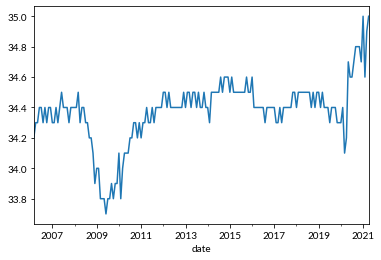

In [10]:
data.TOTCES.dropna().plot()

<AxesSubplot:xlabel='date'>

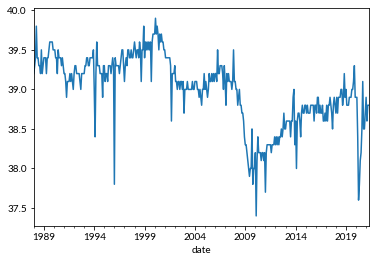

In [11]:
data.TOTLFS.dropna().plot()

### Flows

In [2]:
df = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date')).loc['1990':, ['NILF', 'UNEMP']]
df['TOTAL'] = df.astype('float').sum(axis=1)
sh = (df['NILF'] / df['TOTAL']).rename('total') * 100

sh.to_csv(data_dir / 'lf_flow.csv', index_label='date', header=True, float_format='%g')

ma = sh.resample('QS').mean().rename('quarterly')

ma.to_csv(data_dir / 'lf_flow_q.csv', index_label='date', header=True)
write_txt(text_dir / 'lf_flow_node.txt', end_node(ma, 'green!60!teal!90!black'))

totval = df['TOTAL'].iloc[-1] / 1000
nilfval = df['NILF'].iloc[-1] / 1000
unval = df['UNEMP'].iloc[-1] / 1000

shval = sh.iloc[-1]
maval = ma.iloc[-1] 
sh3y = sh.iloc[-37]

ltdate = dtxt(sh.index[-1])['mon1']
yragodt = dtxt(sh.index[-37])['mon1']

text = (f'In {ltdate}, {totval:.1f} million people were newly employed (on a gross basis). '+
        f'Of these, {shval:.1f} percent were not looking for work in the prior month '+
        '(see {\color{lime!50!green!60!white}\\textbf{---}}). Over the past three months, an average '+
        f'of {maval:.1f} percent of the newly employed were not looking for work the month prior '+
        '(see {\color{green!60!teal!90!black}\\textbf{---}}). With low unemployment, new employees '+
        'are being pulled from outside of the labor force and bypassing unemployment. '+
        f'Three years ago, in {yragodt}, {sh3y:.1f} percent '+
        'of the newly employed were not looking for work a month prior.')

write_txt(text_dir / 'lf_flow.txt', text)
text

'In April 2021, 7.0 million people were newly employed (on a gross basis). Of these, 67.3 percent were not looking for work in the prior month (see {\\color{lime!50!green!60!white}\\textbf{---}}). Over the past three months, an average of 67.3 percent of the newly employed were not looking for work the month prior (see {\\color{green!60!teal!90!black}\\textbf{---}}). With low unemployment, new employees are being pulled from outside of the labor force and bypassing unemployment. Three years ago, in April 2018, 71.9 percent of the newly employed were not looking for work a month prior.'

### Wage Growth

In [3]:
data1, data2 = pd.Series(dtype='float64'), pd.Series(dtype='float64')
columns = ['MONTH', 'YEAR', 'AGE', 'PWORWGT', 'WKEARN', 'HRSUSL1', 'WORKFT']
for year in range(1989, 2022):
    df = (pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
        .query('WKEARN > 0 and WORKFT == 1'))
    data = df.groupby(['YEAR', 'MONTH']).apply(binned_wage)
    data.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data.index]
    data1 = data1.append(data)
    
df = pd.DataFrame({'All': data1})
df = df.rolling(3).mean()

df.rolling(3).mean().to_csv(data_dir / 'uwe_bd.csv', index_label='date')
dfgr = (df.pct_change(12).dropna() * 100).rolling(3).mean()
dfgr.to_csv(data_dir / 'uwe_bd_gr.csv', index_label='date')

srs = ['p10uwe']
df2 = (pd.read_csv(data_dir / 'jobs_report_main2.csv', parse_dates=['date'])
        .set_index('date')).loc['1988':, srs].dropna()
df2.name = 'p10uwe'

df2.to_csv(data_dir / 'uwe_bls.csv', index_label='date')
df2gr = (df2.pct_change(4).dropna() * 100)
df2gr.to_csv(data_dir / 'uwe_bls_gr.csv', index_label='date')

In [4]:
ldate1 = dtxt(df.index[-1])['mon1']
lval1 = df['All'].iloc[-1].round()
lgrval1 = dfgr['All'].iloc[-1].round()
prdate1 = dtxt(df.index[-2])['mon1']
prval1 = df['All'].iloc[-2].round()
prgrval1 = dfgr['All'].iloc[-2].round()
pr2date1 = dtxt(df.index[-3])['mon1']
pr2val1 = df['All'].iloc[-3].round()
pr2grval1 = dfgr['All'].iloc[-3].round()
pr3date1 = dtxt(df.index[-13])['mon1']
pr3val1 = df['All'].iloc[-13].round()


ldate2 = dtxt(df2.index[-1])['qtr1']
lval2 = df2['p10uwe'].iloc[-1]
prdate2 = dtxt(df2.index[-5])['qtr1']
pr2date2 = dtxt(df2.index[-2])['qtr1']
prval2 = df2['p10uwe'].iloc[-5]
lgrval2 = df2gr['p10uwe'].iloc[-1]
lgr2val2 = df2gr['p10uwe'].iloc[-2]

text = ('BLS \href{https://www.bls.gov/webapps/legacy/cpswktab5.htm}{calculations} '+
        f'(see {{\color{{blue!65!black}}\\textbf{{---}}}}) for {ldate2} '+
        'show nominal first decile usual weekly '+
        f'earnings of \${lval2:.2f}, compared to \${prval2:.2f} in {prdate2}, resulting '+
        f'in one-year growth of {lgrval2:.1f} percent. In the previous quarter, {pr2date2}, '+
        f'first decile usual weekly earnings grew by {lgr2val2:.1f} percent over the year. '+
        "Author's calculations from the CPS (see {\color{lime!65!green}\\textbf{---}}) "+
        'show three-month moving average first decile usual weekly '+
        f'earnings of \${lval1:.2f} in {ldate1}, \${prval1:.2f} in {prdate1}, '+
        f'and \${pr3val1:.2f} in {pr3date1}. One-year growth was {lgrval1:.1f} percent for '+
        f'the three months ending {ldate1}, {prgrval1:.1f} percent for the '+
        f'three months ending {prdate1}, and {pr2grval1:.1f} percent for the '+
        f'three months ending {pr2date1}.')
write_txt(text_dir / 'uwe_basic.txt', text)
print(text)

BLS \href{https://www.bls.gov/webapps/legacy/cpswktab5.htm}{calculations} (see {\color{blue!65!black}\textbf{---}}) for 2021 Q1 show nominal first decile usual weekly earnings of \$486.00, compared to \$468.00 in 2020 Q1, resulting in one-year growth of 3.8 percent. In the previous quarter, 2020 Q4, first decile usual weekly earnings grew by 4.5 percent over the year. Author's calculations from the CPS (see {\color{lime!65!green}\textbf{---}}) show three-month moving average first decile usual weekly earnings of \$494.00 in April 2021, \$488.00 in March 2021, and \$486.00 in April 2020. One-year growth was 4.0 percent for the three months ending April 2021, 5.0 percent for the three months ending March 2021, and 6.0 percent for the three months ending February 2021.


### Wages Table

In [5]:
srs = {'First decile': 'p10uwe', 'First quartile': 'p25uwe', 'Median': 'p50uwe', 
       'Third quartile': 'p75uwe', 'Ninth decile': 'p90uwe'}
df = (pd.read_csv(data_dir / 'jobs_report_main2.csv', parse_dates=['date'])
        .set_index('date')).loc['2000':, srs.values()].dropna()

final = pd.DataFrame()
for i in [-1, -2, -3, -4, -5, -9, -13, -17, -21]:
    final[dtxt(df.index[i])['qtr1']] = df.pct_change(4).iloc[i] * 100

final.index = srs.keys()
final.round(1).to_csv(data_dir / 'wage_dist_bls.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

final = pd.DataFrame()
for i in [-1, -2, -3, -4, -5, -9, -13, -17, -21]:
    final[dtxt(df.index[i])['qtr1']] = df.iloc[i]

final.index = srs.keys()
final.round(0).astype('int').to_csv(data_dir / 'wage_dist_bls2.tex', sep='&', 
                                    line_terminator='\\\ ', quotechar=' ')

### Average Hourly Earnings

In [25]:
df = (pd.read_csv(data_dir / 'jobs_report_main2.csv', parse_dates=['date'])
        .set_index('date'))
data = (df[['ALL', 'PNS']].pct_change(12) * 100).loc['1989':]
data.to_csv(data_dir / 'ahe.csv', index_label='date')

ldate = dtxt(data.index[-1])['mon1']
alllt = data['ALL'].iloc[-1]
all_lt = f'{["increased" if alllt >= 0 else "decreased"][0]} by {abs(alllt):.1f} percent'
pnslt = data['PNS'].iloc[-1]
pns_lt = f'{["increased" if pnslt >= 0 else "decreased"][0]} by {abs(pnslt):.1f} percent'

s = series_info(df['ALL'])
all3m = (((s['last_3m'] / s['prev_3m'])**4) - 1) * 100
all_3m = f'{["increased" if all3m >= 0 else "decreased"][0]} at an annual rate of {abs(all3m):.1f} percent'

s = series_info(df['PNS'])
pns3m = (((s['last_3m'] / s['prev_3m'])**4) - 1) * 100
pns_3m = f'{["increased" if pns3m >= 0 else "decreased"][0]} at an annual rate of {abs(pns3m):.1f} percent'

text = (f'Over the year ending {ldate}, nominal wages {all_lt} '+
        'for all employees (see {\color{magenta}\\textbf{---}}) '+
        f'and {pns_lt} for production and non-supervisory workers '+
        '(see {\color{blue!80!black}\\textbf{---}}), according to the '+
        'Bureau of Labor Statistics. Comparing the latest '+
        f'three months to the previous three months, nominal wages {all_3m} '+
        f'for all employees and {pns_3m} for production and non-supervisory '+
        'employees.')

write_txt(text_dir / 'ahe_summary.txt', text)

text

'Over the year ending April 2021, nominal wages increased by 0.3 percent for all employees (see {\\color{magenta}\\textbf{---}}) and increased by 1.2 percent for production and non-supervisory workers (see {\\color{blue!80!black}\\textbf{---}}), according to the Bureau of Labor Statistics. Comparing the latest three months to the previous three months, nominal wages increased at an annual rate of 3.1 percent for all employees and increased at an annual rate of 3.7 percent for production and non-supervisory employees.'

### AHE by Industry

In [26]:
series = {'CES3000000008': 'Manufacturing',
          'CES1000000008': 'Mining \& Logging',
          'CES4422000008': 'Utilities',
          'CES4142000008': 'Wholesale Trade',
          'CES5000000008': 'Information',
          'CES5500000008': 'Financial Activities',
          'CES6000000008': 'Professional \& Business Services',
          'CES6500000008': 'Education \& Health Services',
          'CES0500000008': 'Total Private',
          'CES2000000008': 'Construction',
          'CES7000000008': 'Leisure \& Hospitality',
          'CES4300000008': 'Transportation \& Warehousing',
          'CES4200000008': 'Retail Trade'}

years = (2017, 2021)
df = bls_api(series, years, bls_key)
df.to_csv(data_dir / 'ahe_industry_raw.csv', index_label='date')

Post Request Status: REQUEST_SUCCEEDED


In [6]:
s = pd.read_csv(data_dir / 'cpi.csv')
df = (pd.read_csv(data_dir / 'ahe_industry_raw.csv', parse_dates=['date'])
        .set_index('date'))
allitems = s['ALL'].iloc[-1]
data = (df.pct_change(12).iloc[-1] * 100.0).sort_values(ascending=False)

(data.to_csv(data_dir / 'ahe_ind.csv', index_label='name', header=True))

write_txt(text_dir / 'ahe_bar_date.txt', df.index[-1].strftime('%B %Y'))

real = (data - allitems).drop('Total Private')
ltd = {i: (data.index[i].lower(), data.iloc[i]) for i in [0, 1, 2]}

txt1 = (f'By industry, {len(real.loc[real > 0])} of {len(real)} groups '+
         'experienced real wage growth (wage growth above the increase in '+
        f'prices indicated by the consumer price index). The {ltd[0][0]} '+
        f'industry had the fastest nominal growth rate, at {ltd[0][1]:.1f} percent, followed '+
        f'by {ltd[1][1]:.1f} percent in {ltd[1][0]} and {ltd[2][1]:.1f} percent in {ltd[2][0]}. ')
write_txt(text_dir / 'ahe_comp.txt', txt1)
print(txt1)

if data.min() < 0:
    dm = f'{data.min() - 1:.1f}'
else:
    dm = 0

text = ('\\noindent \hspace*{-2mm} \\begin{tikzpicture}'+
        '\\begin{axis}[\\barplotnogrid axis y line=left, \\barylab{4.0cm}{1.5ex}'+
        'width=6.2cm, bar width=1.8ex, height=7.2cm, xtick={0}, xmajorgrids,'+
        f'enlarge y limits={{abs=3mm}}, enlarge x limits=0.02, xmin={dm},'+
        f'\dbar{{x}}{{{allitems:.2f}}}, clip=false,'+
        'yticklabels from table={\\ahe}{name},'+
        'yticklabel style={font=\\footnotesize},'+
        'nodes near coords style={/pgf/number format/.cd, fixed zerofill,'+
        'precision=1, assume math mode}]'+
        '\\addplot[fill=blue!80!black, draw=none] '+
        'table [y expr=-\coordindex, x index=1] {\\ahe};'+
        f'\\node[right] at ({allitems:.2f}, -12.6) {{\\footnotesize \\textcolor{{black!80}}{{CPI}}}};'+
        '\end{axis}'+
        '\end{tikzpicture}\\\ '+
        '\\footnotesize{Source: Bureau of Labor Statistics} \hspace{48mm} \\tbllink{ahe_ind.csv}')
write_txt(text_dir / 'ahe_chart.txt', text)
print(text)

By industry, 6 of 12 groups experienced real wage growth (wage growth above the increase in prices indicated by the consumer price index). The leisure \& hospitality industry had the fastest nominal growth rate, at 6.8 percent, followed by 5.3 percent in construction and 4.7 percent in utilities. 
\noindent \hspace*{-2mm} \begin{tikzpicture}\begin{axis}[\barplotnogrid axis y line=left, \barylab{4.0cm}{1.5ex}width=6.2cm, bar width=1.8ex, height=7.2cm, xtick={0}, xmajorgrids,enlarge y limits={abs=3mm}, enlarge x limits=0.02, xmin=0,\dbar{x}{4.15}, clip=false,yticklabels from table={\ahe}{name},yticklabel style={font=\footnotesize},nodes near coords style={/pgf/number format/.cd, fixed zerofill,precision=1, assume math mode}]\addplot[fill=blue!80!black, draw=none] table [y expr=-\coordindex, x index=1] {\ahe};\node[right] at (4.15, -12.6) {\footnotesize \textcolor{black!80}{CPI}};\end{axis}\end{tikzpicture}\\ \footnotesize{Source: Bureau of Labor Statistics} \hspace{48mm} \tbllink{ahe_ind

### CES data

In [28]:
series = {'CES0000000001': 'ALL',
          'LNU00000000': 'TOT',
          'CES3000000001': 'Manufacturing',
          'CES1000000001': 'Mining \& Logging',
          'CES4422000001': 'Utilities',
          'CES4142000001': 'Wholesale Trade',
          'CES5000000001': 'Information',
          'CES5500000001': 'Financial Activities',
          'CES6000000001': 'Professional \& Business Serv.',
          'CES6500000001': 'Education \& Health Services',
          'CES0500000001': 'Total Private',
          'CES2000000001': 'Construction',
          'CES7000000001': 'Leisure \& Hospitality',
          'CES4300000001': 'Transportation \& Warehousing',
          'CES4200000001': 'Retail Trade',
          'CES9000000001': 'Government'}
years = (2011, 2021)
df = bls_api(series, years, bls_key)
df.to_csv(data_dir / 'ces_data.csv', index_label='date')

Post Request Status: REQUEST_SUCCEEDED


In [29]:
df = pd.read_csv(data_dir / 'ces_data.csv').set_index('date')
data = df['ALL'].diff().loc['2017':]
data.div(1000).to_csv(data_dir / 'nfp.csv', index_label='date', header='ALL')
ldate = dtxt(data.index[-1])['mon1']
pdate = dtxt(data.index[-2])['mon1']

lval = data.iloc[-1]
if lval > 0:
    lvaltxt = 'added'
else:
    lvaltxt = 'lost'
pval = data.iloc[-2]
if pval > 0:
    pvaltxt = 'added'
else:
    pvaltxt = 'lost'
l3val = data.iloc[-3:].mean()
if l3val > 0:
    l3valtxt = 'added'
else:
    l3valtxt = 'lost'

emp = df.loc['2015':, 'ALL']
tot = df.loc['2015':, 'TOT']

final2 = (((emp / tot).shift(1) * tot).round(-3) / 1000).rolling(12).mean()
final2.to_csv(data_dir / 'nfp_pop.csv', index_label='date', header=['TOT'])

lpop = final2.iloc[-3:].mean().round(-1)

covloss = abs(data.loc['2020-03-01':'2020-04-01'].sum())  / 1000
since = data.loc['2020-05-01':].sum() / 1000

rec_pct = since / covloss
if rec_pct < 1:
    rpct = f' ({rec_pct*100:.1f} percent)'
else:
    rpct = ''
    
pre = data.loc['2019-03-01':'2020-02-01'].mean()

text = (f'The US {lvaltxt} {abs(lval):,.0f},000 jobs in {ldate}, compared to '+
        f'{abs(pval):,.0f},000 {pvaltxt} in {pdate}, and an average of '+
        f'{abs(l3val):,.0f},000 {l3valtxt} over '+
        f'the past three months. US payrolls shed a combined {covloss:.1f} million jobs '+
        f'in March and April 2020 and have since recovered {since:.1f} million jobs{rpct}.'+
        '\n \nTo maintain a steady employment rate with '+
        'population growth, the US needs to '+
        f'add around {lpop:.0f},000 jobs per month. During the 12 months prior to the COVID-'+
        'related job losses '+
        f'the US was adding an average of {pre:,.0f},000 jobs per month.')
write_txt(text_dir / 'nfp_basic_text.txt', text)
print(text)

The US added 266,000 jobs in April 2021, compared to 770,000 added in March 2021, and an average of 524,000 added over the past three months. US payrolls shed a combined 22.4 million jobs in March and April 2020 and have since recovered 14.1 million jobs (63.3 percent).
 
To maintain a steady employment rate with population growth, the US needs to add around 140,000 jobs per month. During the 12 months prior to the COVID-related job losses the US was adding an average of 202,000 jobs per month.


In [30]:
data = (pd.read_csv(data_dir / 'ces_data.csv')
          .set_index('date')
          .drop(['TOT', 'Total Private'], axis=1)
          .rename({'ALL': '\\textbf{Total}'}, axis=1))

final = pd.DataFrame()
for i in [-1, -13]:
    final[dtxt(data.index[i])['mon2']] = data.iloc[i]
    
final[dtxt(data.index[-1])['mon2'] + ' '] = data.diff().iloc[-1]
for i in [-2, -3]:
    final[dtxt(data.index[i])['mon2']] = data.diff().iloc[i]
    
final['Mar `19 to Feb `20 avg'] = data.diff().loc['2019-03-01':'2020-02-01'].mean()    
    
final['Since May 2020'] = data.iloc[-1] - data.loc['2020-04-01']
final['Mar and Apr `20'] = data.diff().loc['2020-03-01':'2020-04-01'].sum()

final = final.sort_values(dtxt(data.index[-1])['mon2'], ascending=False).astype(int).applymap('{:,.0f}'.format)
final.to_csv(data_dir / 'nfp.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

final

,Apr 2021,Apr 2020,Apr 2021,Mar 2021,Feb 2021,Mar `19 to Feb `20 avg,Since May 2020,Mar and Apr `20
\textbf{Total},"144,308","130,161",266,770,536,202,"14,147","-22,362"
Education \& Health Services,"23,395","21,722",-1,104,57,54,"1,673","-2,843"
Government,"21,591","21,826",48,62,-86,28,-235,"-1,009"
Professional \& Business Serv.,"20,721","19,082",-79,67,93,25,"1,639","-2,387"
Retail Trade,"15,210","13,235",-15,32,14,-4,"1,974","-2,374"
Leisure \& Hospitality,"14,067","8,691",331,206,413,37,"5,376","-8,224"
Manufacturing,"12,284","11,414",-18,54,35,-2,870,"-1,385"
Financial Activities,"8,812","8,596",19,19,-7,15,216,-279
Construction,"7,452","6,535",0,97,-57,19,917,"-1,113"
Transportation \& Warehousing,"5,681","5,248",-74,44,36,19,432,-574


### Government Jobs

In [31]:
df1 = (pd.read_csv(data_dir / 'jobs_report_main.csv', parse_dates=['date'])
        .set_index('date'))

df2 = (pd.read_csv(data_dir / 'jobs_report_main2.csv', parse_dates=['date'])
        .set_index('date'))

gj = df2['govjobs']
data = ((gj / df1['POP']) * 100)
data.name = 'GOVJOBS'
data.to_csv(data_dir / 'govjobs.csv', index_label='date', header=True)
node = end_node(data, 'blue!50!cyan', date=True)
write_txt(text_dir / 'govjobs_node.txt', node)

ltdate = dtxt(gj.index[-1])['mon1']
pryrdate = dtxt(gj.index[-13])['mon1']

ltval = gj.iloc[-1] / 1000 
pryrval = gj.iloc[-13] / 1000 
ltsh = data.iloc[-1]
pryrsh = data.iloc[-13]

diff = gj.iloc[-1] - gj.loc['2020-02-01']
if diff > 950:
    difftxt = f'gained {diff / 1000:.1f} million'
elif diff > 0:
    difftxt = f'gained {diff:.0f},000'
elif diff < -950:
    difftxt = f'lost {abs(diff) / 1000:.1f} million'
else:
    difftxt = f'lost {abs(diff):.0f},000'
    
text = (f'In {ltdate}, there were {ltval:.1f} million government jobs, '+
        f'equivalent to {ltsh:.1f} for every 100 people in the age 16+ population '+
        '(see {\color{blue!50!cyan}\\textbf{---}}). The previous year, in '+
        f'{pryrdate}, there were {pryrval:.1f} million government jobs, '+
        f'equivalent to {pryrsh:.1f} percent of the age 16 or older population. '+
        f'Since February 2020, the US has {difftxt} total government jobs. ')
print(text)

In April 2021, there were 21.6 million government jobs, equivalent to 8.3 for every 100 people in the age 16+ population (see {\color{blue!50!cyan}\textbf{---}}). The previous year, in April 2020, there were 21.8 million government jobs, equivalent to 8.4 percent of the age 16 or older population. Since February 2020, the US has lost 1.2 million total government jobs. 
